# Answering the Question: What characters does The Data say I should use?
## Author: Kevin Stull


## Introduction
Fire Emblem Engage presents us with a simple problem, given 36 possible characters, which 10 or so should we put on our team? Should I just commit to the weaker early game character or hold off for this character in the late-game? What characters are best? 

## Spoiler Warning 
There are going to be (heavy) spoilers in the article. There are many plot-relevant playable characters in FE Engage. We are literally examining every unit in the game so it is assumed that the player is farmiliar with (or does not care about) the plot of Fire Emblem Engage.

## What We Are Going To Do 
There are three things that we need to consider; bases, growths, and availability. The first two have been investigated in article 1. The tricky part is deciding how to deal with the character's availability. For example, in the first article we saw that Mavier had the highest total growths and the highest total bases, however he was the worst character in terms of availability, being the last obtainable character on the roster of 36. Simply stating that Mavier is the best tank and moving on does not help us, because we will have to complete most of the game before even getting to him, so what characters should we have used in the mean time. On the other end of the spectrum, barring Alear, most of the characters obtained very early are quite poor (Etie, Bucheron, ect.). The first characters that seemed to be worth considering were Alfred and Citrine, which isn't suprising since they are "plot-relevant" characters with unique promotions. However, at the same time, we meet characters like Louis and Chloe, some more fan favorites. To address this we are going to leverage a machine learning technique called regression. 

## What is Regression and Why Will it Help?
Regression is a simple concept with some powerful applications. Let us start by imagining that we have a graph of all the characters in the game where the x-axis represents what chapter you can recruit them and y represents how powerful they are. We saw from article 1 that later on in the game, characters tend to have more bases and better growths, thus as x increases so does y.

To perform regression, we will try to find constants A, B, and C such that $Ax^2 + Bx + C$ predicts about how strong (y) a unit will be at some chapter (x) in the game. 

I selected a quadratic (function with x to the power of 2) because that is what the curves roughly looked like in article 1. Once we have this line that predicts how strong we expect a unit to be at some chapter, we will look at which characters are the furthest above that curve. That would mean that these characters are much stronger than we would expect a character to be at that chapter of the game. Thus, giving XP to them will on average lead to a stronger character later on in the game even if we encounter another unit that might fill the same role.

## Example: Which Character Should We Use? 
Let's say we need to choose between using Etie, Kagetsu, Timerra, and Lindon on our team. Lindon has better bases than everyone else but is only available very late. Etie has worse base stats than everyone else but is available earlier than everyone else. The red line indicates how strong we believe a unit should be at some chapter in the game. Kagetsu has the same as (or even slightly better) base stats than Timerra and is available 2 chapters earlier. That means that Kagetsu is stronger than we would typically expect a unit with his availability to be. He is a positive outlier on our Desirability Chart so we should select him for our team. 

## Plot of Unit Desirability

<img src="/Users/kevinstull/Documents/projects/FE_Engage/Article_2/figs/Screenshot 2024-01-12 at 11.46.44 AM.png" alt="Description of the image" width="650" height="500">


## Basic Approach 
1) Create a graph containing all the characters where x is the chapter you can recruit them and y is their power level. 
2) Use regression to find a best-fit quadratic function to our data 
3) Rank all of the character's desirability in terms of how far above the expected powere level line they are 
4) Select the top N characters to build your team (where N is the size of your team)

## Assumptions 
In order to answer this question we are going to make a few assumptions. Number 1, we will assume that the classes are balanced, this means that a lvl 10 swordmaster is just as strong as a lvl 10 mage. While this assumption is almost certainly flawed, it gives us a nice starting point for our investigation which we can remove in later articles. 2nd, we are going to assume that every unit will have average growths. We could also investigate when certain characters become better or worse given random level ups, or just the level up schedule Nintendo provided, but for now, just to simplify things, we assume that the units always perfectly follow their growth curves. Lastly, we will ignore their innate skills. Obviously some characters have better innate abilities that others, but it isn't clear how one would quantify them numerically, so we will assume they are all even and in the case of ties, their passive can be used as a "tie-breaker". With that, we are ready to dive in! 



## Who is the best physical tank to use? 
We are going to look for the best physical tank, which we expect to have high HP and Def. We will be using min-max normalization, if you need a refresher on that go see the last section of article 1! Basically, we are going to normalize HP and Def growths then add them together, we will do the same for bases, then we will add the growths to the bases to get an idea of how strong the character is for physical tanking. We should expect characters like Mauvier and Louis to be near the top of this graph and characters like Lindon and Citrine to be near the bottom. 


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

def normalize_and_combine(features, f_name, df_char_bases, df_char_growths, combined_df):
    # Initialize MinMaxScalers
    scalers = {feature: MinMaxScaler() for feature in features}

    # Create copies of DataFrames
    bases_norm = df_char_bases.copy()
    growths_norm = df_char_growths.copy()

    # Normalize features
    for feature in features:
        bases_norm[feature] = scalers[feature].fit_transform(bases_norm[[feature]])
        growths_norm[feature] = scalers[feature].fit_transform(growths_norm[[feature]])

    # Create 'phys_tank' columns
    bases_norm[f_name] = bases_norm[features].sum(axis=1)
    growths_norm[f_name] = growths_norm[features].sum(axis=1)

    # Combine 'Name' and 'phys_tank' columns
    combined_df['Name'] = bases_norm['Name']
    combined_df[f_name] = bases_norm[f_name].values + growths_norm[f_name].values

    return combined_df

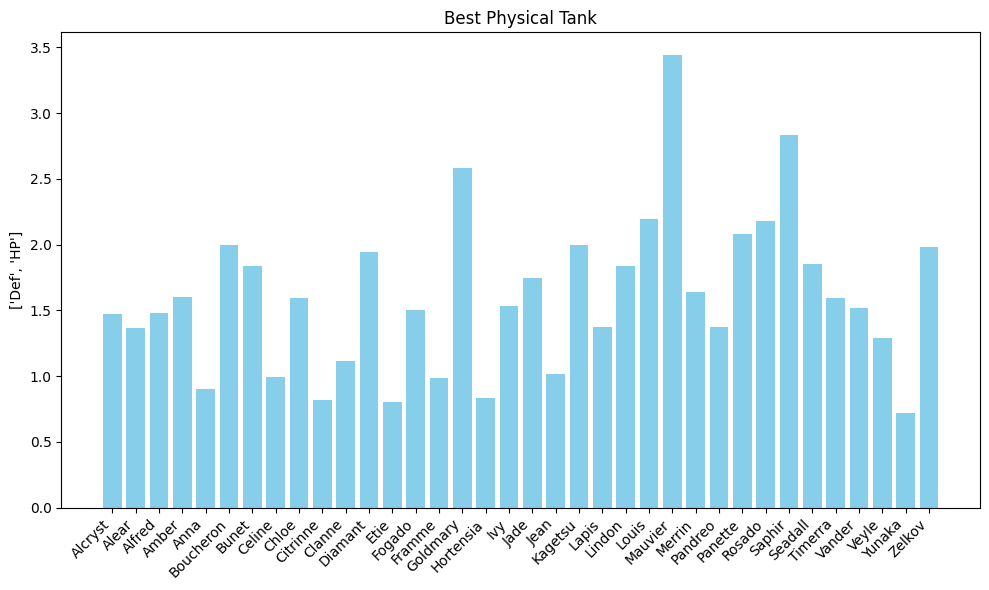

In [28]:
df_char_bases = pd.read_csv('fe_17_data_char_bases.csv')
df_char_growths = pd.read_csv('fe_17_data_char_growths.csv')
df_char_bases = df_char_bases.sort_values(by='Name').reset_index(drop=True)
df_char_growths = df_char_growths.sort_values(by='Name').reset_index(drop=True)
temp = pd.merge(df_char_bases, df_char_growths[['Name', 'Ch_Rec']], on='Name', how='left')
df_char_bases['Ch_Rec'] = temp['Ch_Rec'] 

# Our Combined Data Frame for Regression 
combined_df = pd.DataFrame()

# Physical Tank
features = ['Def', 'HP'] 
f_name = 'phys_tank'

combined_df = normalize_and_combine(features, f_name, df_char_bases, df_char_growths, combined_df)
#combined_df = combined_df.sort_values(by=f_name, ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(combined_df['Name'], combined_df[f_name], color='skyblue')
plt.ylabel(str(features))
plt.title('Best Physical Tank')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


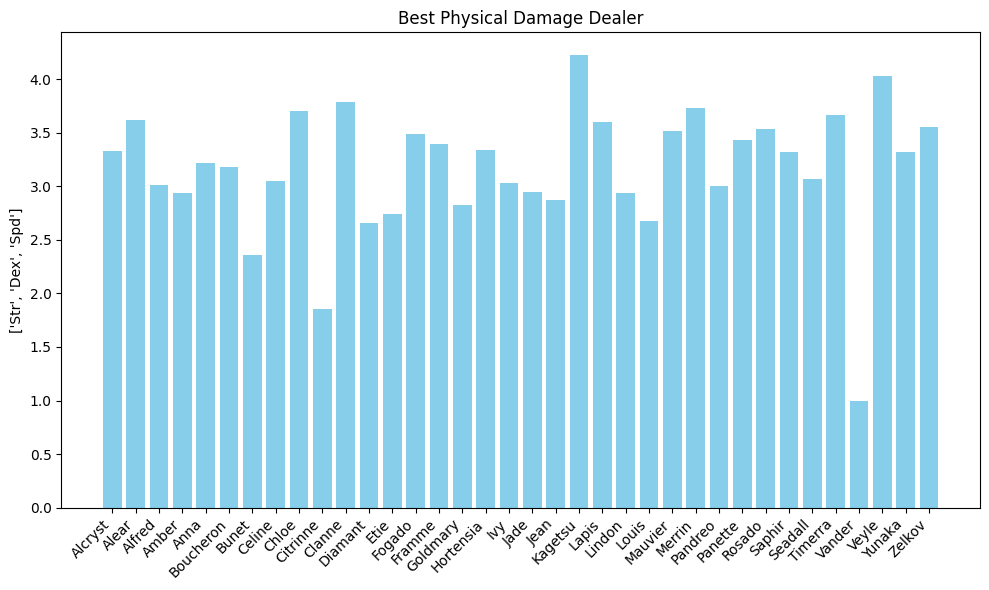

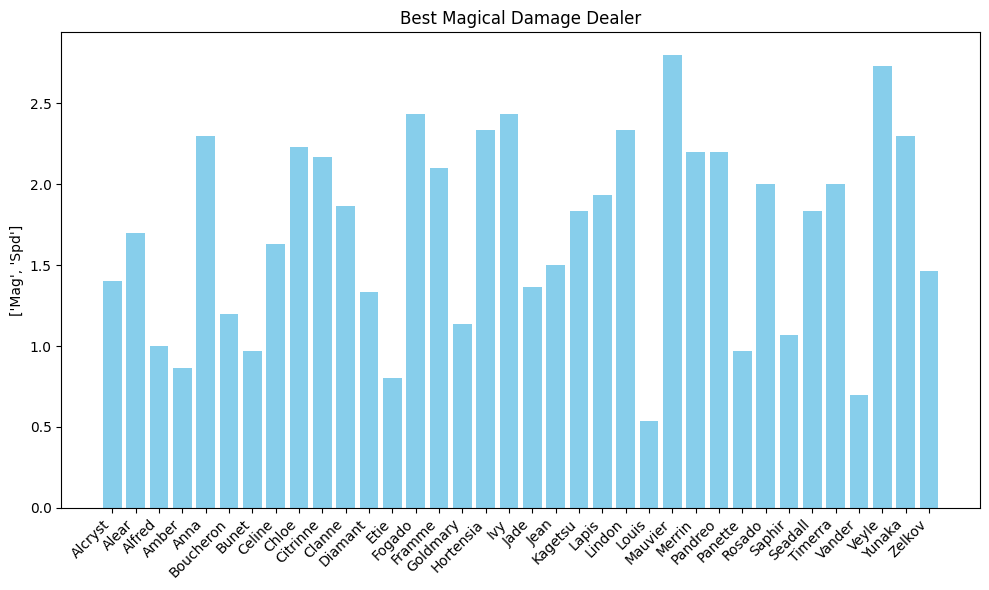

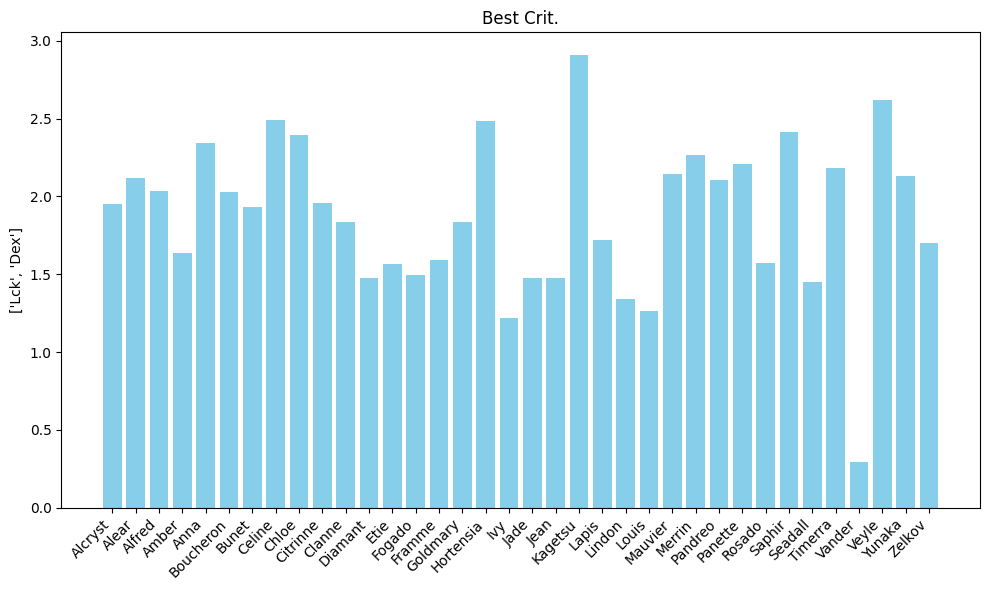

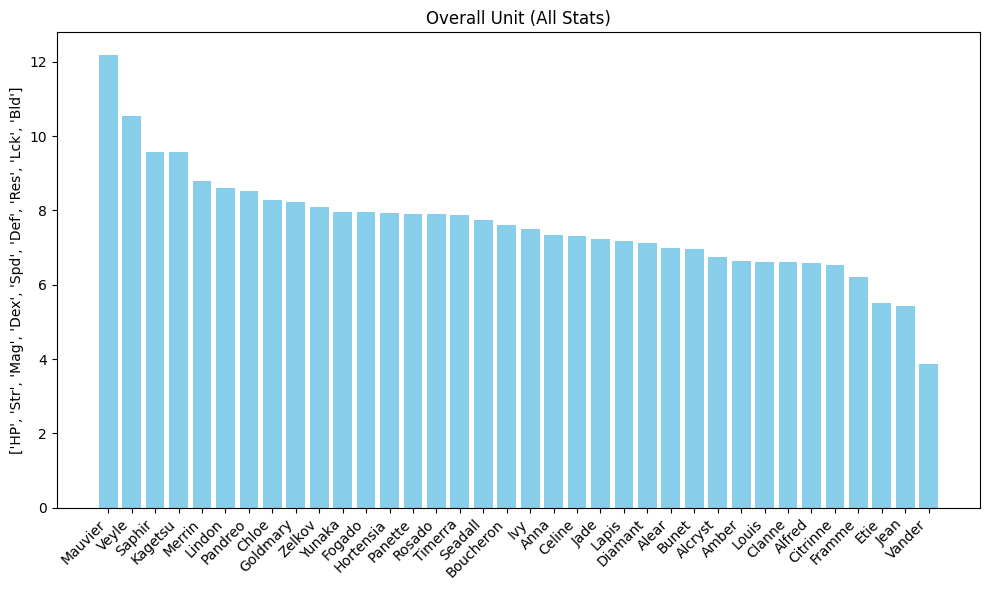

In [29]:

# Physical Damage Dealer 
features = ['Str', 'Dex', 'Spd']
f_name = 'phys_dam'
combined_df = normalize_and_combine(features, f_name, df_char_bases, df_char_growths, combined_df)
#combined_df = combined_df.sort_values(by=f_name, ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(combined_df['Name'], combined_df[f_name], color='skyblue')
plt.ylabel(str(features))
plt.title('Best Physical Damage Dealer')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Magical Damage Dealer 
features = ['Mag', 'Spd']
f_name = 'mag_dam'
combined_df = normalize_and_combine(features, f_name, df_char_bases, df_char_growths, combined_df)
#combined_df = combined_df.sort_values(by=f_name, ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(combined_df['Name'], combined_df[f_name], color='skyblue')
plt.ylabel(str(features))
plt.title('Best Magical Damage Dealer')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Best Crit. 
features = ['Lck', 'Dex']
f_name = 'crit'
combined_df = normalize_and_combine(features, f_name, df_char_bases, df_char_growths, combined_df)
#combined_df = combined_df.sort_values(by=f_name, ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(combined_df['Name'], combined_df[f_name], color='skyblue')
plt.ylabel(str(features))
plt.title('Best Crit.')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# All stats 
features = ['HP','Str','Mag','Dex','Spd','Def','Res','Lck','Bld']
f_name = 'all_stats'
combined_df = normalize_and_combine(features, f_name, df_char_bases, df_char_growths, combined_df)
#combined_df = combined_df.sort_values(by=f_name, ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(combined_df['Name'], combined_df[f_name], color='skyblue')
plt.ylabel(str(features))
plt.title('Overall Unit (All Stats)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()